# Liberty Project

This notebook will demonstrate the work I have done for a data science project as part of the interview process for Liberty Oilfield Services <br>
<br>
The following are the objective and 5 guidelines to deliver on that objective: <br>
<br>

> Develop a machine learning pipeline that:
> 1. Ingests temperature telemetry data from an external API in real-time.
> 2. Performs exploratory data analysis to understand the data.
> 3. Builds a model to predict the temperature for the next hour.
> 4. Continuously evaluates and updates the model as new data becomes available.
> 5. Generates alerts when the predicted temperature exceeds a threshold.


## 0. Preparation

First, I want to get all of the previous data I can. According the documentation, 92 days is the maximum.

In [2]:
!pip install schedule

In [3]:
# Standard library imports
from datetime import datetime
import warnings

# Third-party imports
import requests
import schedule
from schedule import repeat, every, run_pending
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error

In [4]:
# Ignoring warnings
warnings.filterwarnings('ignore') 

In [5]:
# Defining parameters
# These are the points of longitude and latitude requested in the project instructions
# 'minutely_15' specifies that we want data points from every 15 minutes 
# For this particular step I just want past, real data. Not forecast.
weather_params = {
    "latitude": 35.49,
    "longitude": -97.96,
    "temperature_unit": "fahrenheit",
    "minutely_15": "temperature_2m",
    "forecast_days": 0,
    "past_days": 92
}



# Making the request and capturing it's response
response = requests.get("https://api.open-meteo.com/v1/forecast", params=weather_params)

In [6]:
# Getting the data from the response
past_temp_data = response.json()['minutely_15']

The output is vast for this, so I won't give any output until we get this into a dataframe.

In [7]:
# Converting JSON into a pandas dataframe
df = pd.DataFrame(past_temp_data)

In [8]:
# Taking a look at the dataframe
df

,time,temperature_2m
0,2024-11-19T00:00,52.8
1,2024-11-19T00:15,52.9
2,2024-11-19T00:30,53.1
3,2024-11-19T00:45,53.2
4,2024-11-19T01:00,53.4
...,...,...
8827,2025-02-18T22:45,8.1
8828,2025-02-18T23:00,6.4
8829,2025-02-18T23:15,6.3
8830,2025-02-18T23:30,6.5


In [9]:
# For some reason, some of the earliest data points are missing. I will remove them before writing the csv.
df_without_nans = df[df['temperature_2m'].notna()]

In [10]:
# Writing the CSV
df_without_nans.to_csv("/kaggle/working/past_telemetry_data.csv", index=False)

## 1. Data Ingestion

In [12]:
# Formatting parameters to get only the previous 15 minutes' temperature
weather_params = {
    "latitude": 35.49,
    "longitude": -97.96,
    "temperature_unit": "fahrenheit",
    "minutely_15": "temperature_2m",
    "past_minutely_15": 1,
    "forecast_minutely_15": 0
    
}



def get_15_minutely_temp(params=weather_params):
    # Making the request and capturing it's response
    response = requests.get("https://api.open-meteo.com/v1/forecast", params=params)
    new_data = pd.DataFrame(response.json()['minutely_15'])

    # Loading in telemetry data
    all_data = pd.read_csv("/kaggle/working/past_telemetry_data.csv")
    
    # Appending new data to end of all data
    all_data = pd.concat([all_data, new_data])

    all_data.to_csv("/kaggle/working/current_telemetry_data.csv", index=False)
    print("Ran!")

# Using Python's 'schedule' library to schedule a run every 15 minutes
schedule.every(15).minutes.do(get_15_minutely_temp)

Every 15 minutes do get_15_minutely_temp() (last run: [never], next run: 2025-02-19 17:04:26)

In [ ]:
while True:
    # Running the function to get API data every 15 minutes
    schedule.run_pending()

This code will now send a request to the API every 15 minutes and get data back.

## 2. Exploratory Data Analysis

In [11]:
# Converting ISO 8162 to Unix timestamp for python operations
df['time'] = pd.to_datetime(df['time'])

In [12]:
# Doing some data manipulation to get it ready for plotting
df['day'] = [t.day for t in df['time']]
df['hour'] = [t.hour for t in df['time']]
df['month'] = [t.month for t in df['time']]
df['date'] = [t.date() for t in df['time']]
df['time_of_day'] = [int(t.time().strftime("%H%M")) for t in df['time']]

<Axes: xlabel='hour', ylabel='temperature_2m'>

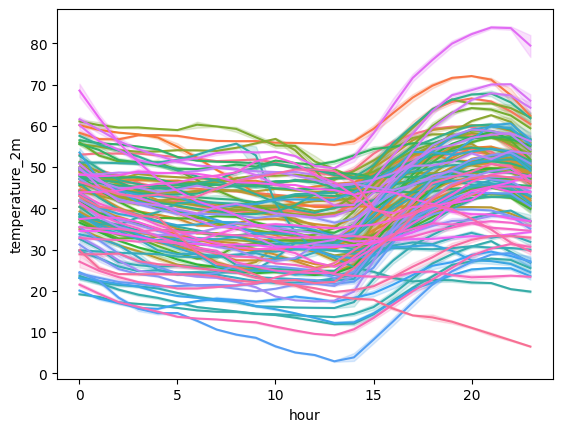

In [13]:
sns.lineplot(df, x="hour", y="temperature_2m", hue="date", legend=False)

It seems to follow a sinusoidal pattern, with the trough during the middle of the day.

There are a few notable outliers, however. One day was abnormally hot during the winter months; another dipped well below the all of the other days in temperature; one day even saw temperatures decrease as the hours increased.

In [22]:
# Getting average temperature for each hour
hourly_means = df.groupby("hour")['temperature_2m'].mean()

outliers = pd.DataFrame()
# Looking at which temperatures differ from these means by more than 40 degrees
for i, temp_mean in enumerate(hourly_means):
    hour_filter = f"hour == {i}"
    temp_filter = f"temperature_2m > {hourly_mean} + 40"
    df_for_hour = df.query(f"hour == {i} and ")

    outliers = pd.concat
    


hour
0     42.927174
1     40.961413
2     39.442391
3     38.453533
4     37.600815
5     36.851630
6     36.239674
7     35.838859
8     35.572826
9     35.189402
10    34.855163
11    34.484239
12    33.937228
13    33.498641
14    34.368207
15    37.134783
16    40.006793
17    42.753804
18    45.079620
19    46.793207
20    47.801902
21    48.116033
22    47.434239
23    45.120109
Name: temperature_2m, dtype: float64
0
42.92717391304348
1
40.96141304347826
2
39.44239130434782
3
38.45353260869565
4
37.60081521739131
5
36.85163043478261
6
36.23967391304348
7
35.83885869565218
8
35.57282608695652
9
35.189402173913045
10
34.855163043478264
11
34.48423913043479
12
33.93722826086957
13
33.49864130434783
14
34.36820652173913
15
37.13478260869565
16
40.00679347826087
17
42.75380434782608
18
45.07961956521739
19
46.79320652173914
20
47.80190217391304
21
48.116032608695654
22
47.43423913043478
23
45.12010869565218


Let's look at month now

<Axes: xlabel='hour', ylabel='temperature_2m'>

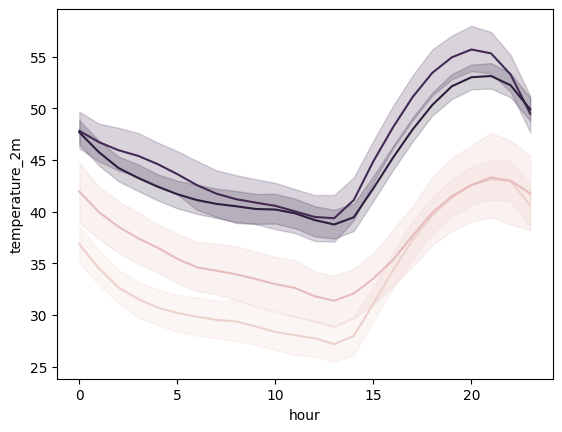

In [16]:
sns.lineplot(df, x="hour", y="temperature_2m", hue="month", legend=False)

Very consistent trend for times of day, with another fairly predictable trend for months of the year

In [ ]:
# Average Temperature by hour of day
df[['temperature_2m', 'hour']].groupby(by=["hour"]).mean()

It looks like `hour` will be a good feature for our model

In [ ]:
# Average Temperature by month
df[['temperature_2m', 'month']].groupby(by=["month"]).mean()

`Month` also seems to be important, and this makes sense with our knowledge of seasons

In [ ]:
# Average Temperature by day of month
df[['temperature_2m', 'day']].groupby(by=["day"]).mean()

These numbers do not follow any sort of pattern, so it follows that `day` is not a good feature.

## 3. Model Development

The features I will use for this model training are `month` and `hour`.

I will also engineer some features, like the temperature from 15 minutes ago and perhaps the previous day

In general, I favor XGBoost for its robust ability to handle an array of use cases. However, I am curious if a neural network might out-perform the regression model. <br>
<br>
My initial thought is that, with the lack of data available, deep learning may be overkill.

### Feature Engineering

In [ ]:
# getting the temperature from the previous 15 minutes
df['previous_15_min_temp'] = df['temperature_2m'].shift(1)

In [ ]:
df

### Model Fitting

In [ ]:
# Splitting data into training and testing
df_train = df.query("month != 2")
df_test = df.query("month == 2")

# Separating x, y, training and testing data
x_cols = ['hour', 'month', 'previous_15_min_temp']
y_col = ['temperature_2m']

x_train = df_train[x_cols]
y_train = df_train[y_col]
x_test = df_test[x_cols]
y_test = df_test[y_col]

In [ ]:
# Create XGBoost classifier
model = xgb.XGBRegressor()

# Fit model to November, December, and January data
model.fit(x_train, y_train)

In [ ]:
# Getting model predictions on test data
y_pred = model.predict(x_test)

In [ ]:
# Creating a small dataframe to view columns side-by-side
y_comp = pd.DataFrame()

y_comp['y_true'] = y_test
y_comp['y_pred'] = y_pred
y_comp['temp_diff'] = abs(y_comp['y_true'] - y_comp['y_pred'])

In [ ]:
y_comp

So far, the predictions are fairly close to actuality. Looking at this on a line plot further confirms this observation.

In [ ]:
sns.lineplot(df_test, x="time", y="temperature_2m")
sns.lineplot(df_test, x="time", y=y_pred)

Only one segment of the month of february looks to be grossly underestimated. Let's look at the 15-minute intervals with the worst predictions

In [ ]:
y_comp.sort_values(by="temp_diff", ascending=False)

My explanation for this is how abnormally high this spike is for this time of year. Perhaps with more data reaching back several years, we could better account for these unusual spikes in predictions

Finally, I want to check the mean absolute error of the predictions. This is an excellent way to quantify the average difference between what the model predicted and what actually occured.<br>



In [ ]:
mean_absolute_error(y_test, y_pred)

In [ ]:
np.median(y_comp['temp_diff'])

On average, our temperature projections are off by less than a degree fahrenheit. The median is even less. With our small set of training data, this feels acceptable

## 4. Real-Time Evaluation and Model Update

Now that the model has been fit and saved, we can make forecasts about future data.

We can also take the new data and re-fit the model, so that our model gradually becomes more robust.

Below, I've written some functions to achieve this process:

In [ ]:
# Constants
# Formatting parameters to get only the previous 15 minutes' temperature
WEATHER_PARAMS = {
    "latitude": 35.49,
    "longitude": -97.96,
    "temperature_unit": "fahrenheit",
    "minutely_15": "temperature_2m",
    "past_minutely_15": 1,
    "forecast_minutely_15": 0
    
}
NEWEST_WEATHER_DATA_PATH = "/kaggle/working/current_telemetry_data.csv"
ORIGINAL_WEATHER_DATA_PATH = "/kaggle/working/past_telemetry_data.csv"
MODEL_SAVE_PATH = "weather_model.json"
API_URL = "https://api.open-meteo.com/v1/forecast"


@repeat(every(15).minutes)
def get_15_minutely_temp(params=WEATHER_PARAMS,
                         original_data_path=ORIGINAL_WEATHER_DATA_PATH,
                         newest_data_path=NEWEST_WEATHER_DATA_PATH):
    # Making the request and capturing it's response
    # api url will not change, so not adding it as an optional arg
    response = requests.get(API_PATH, params=params)
    new_data = pd.DataFrame(response.json()['minutely_15'])

    # Loading in telemetry data
    all_data = pd.read_csv(original_data_path)
    
    # Appending new data to end of all data
    all_data = pd.concat([all_data, new_data])

    all_data.to_csv(newest_data_path, index=False)
    print("Ran!")

    
def fit_xgb_regression_model(df_path=NEWEST_WEATHER_DATA_PATH,
                             model_save_path=MODEL_SAVE_PATH):

    # Loading dataset with newest data
    df = pd.read_csv(df_path)
    
    # Converting ISO 8162
    df['time_of_day'] = [int(t.time().strftime("%H%M")) for t in df['time']]
    
    # Extracting hour and month from timestamp
    df['hour'] = [t.hour for t in df['time']]
    df['month'] = [t.month for t in df['time']]
    
    # getting the temperature from the previous 15 minutes
    df['previous_15_min_temp'] = df['temperature_2m'].shift(1)
    
    # Separating x, y, training and testing data
    x_cols = ['hour', 'month', 'previous_15_min_temp']
    y_col = ['temperature_2m']

    x = df[x_cols]
    y = df[y_col]

    # Create XGBoost classifier
    model = xgb.XGBRegressor()
    
    # Fit model to November, December, and January data
    model.fit(x, y)

    model.save_model("weather_model.json")

I'm leveraging the `schedule` library to incrementally ingest temperature data from the API.

In [ ]:
while True:
    # Running the function to get API data every 15 minutes
    run_pending()

    # Loading in updated dataset
    df = pd.read_csv("/kaggle/working/current_telemetry_data.csv")

    # fitting new model
    fit_xgb_regression_model()

## 5: Alert System

Weather can produce anomalies. It is imperative that we alert the necessary people of an unusually high or low temperature projection.